In [2]:
import pdb
import glob
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.colab import drive, data_table
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# METEOFRANCE

In [37]:
def site_location(lat=0, lon=0):
  sites = {(48.44424057006836, -4.4123148918151855): 'Brest', 
           (48.77284622192383, 2.012406349182129): 'Trappes'}
  try:
    return sites[(lat, lon)]
  except:
    return 'Not known site'

def title1(mytitle, coef):
    """
    inclus le titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.95, mytitle, fontsize=6.5*coef, fontweight='bold',
                horizontalalignment='center', verticalalignment='center')
    return


def title2(mytitle, coef):
    """
    inclus le sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.89, mytitle, fontsize=5.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return


def title3(mytitle, coef):
    """
    inclus le sous sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """
    plt.figtext(0.5, 0.85, mytitle, fontsize=4.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return

def gapsizer(ax, time, range, gapsize, colour='#c7c7c7'):
    """
    This function creates a rectangle of color 'colour' when time gap 
    are found in the array 'time'. 
    """
        # search for holes in data
    # --------------------------------------------------------------------
    dif_time = time[1:] - time[0:-1]
    print(type(dif_time))
    for index, delta in enumerate(dif_time):
        # pdb.set_trace()
        if delta > np.timedelta64(gapsize, 'm'):
            # missing hide bad data
            start = mdates.date2num(time[index])
            end = mdates.date2num(time[index + 1])
            width = end - start

            # Plot rectangle
            end = mdates.date2num(time[index + 1])
            rect = mpl.patches.Rectangle(
                (start, 0), width, np.nanmax(range),
                color=colour)
            ax.add_patch(rect)

def plot_as_me(ds, channel, axes, qt, wl, signal_mode, attrs, save_fig=False, **kwargs):
  cmap = mpl.cm.jet
  bounds = np.linspace(0, 100, 64)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  title1('{instr} {mode} {qt} at {wl} {wlu}'.format(instr=attrs['instrument_id'],
                                                            mode=signal_mode,
                                                            qt=qt,
                                                            wl=wl,
                                                            wlu='nm'), coef=2.5)
  title2(str(ds.time.values[0].astype('datetime64[D]')), coef=2.5)

  title3('{} ({:.1f}N, {:.1f}E)'.format(site_location(float(ds.lat.data[0]), float(ds.lon.data[0])), 
                                           float(ds.station_latitude), 
                                           float(ds.station_longitude)), coef=2.5)
  
  q = ds[channel].sel(range=slice(0, 5000)).plot.pcolormesh(x='time', 
                 y='range', 
                 cmap='jet', 
                 vmin=kwargs['vmin'], 
                 vmax=kwargs['vmax'],
                 # norm=norm
                 )
  
  plt.subplots_adjust(left=0, bottom=0, right=1, top=0.8, wspace=0, hspace=0)
  myFmt = mdates.DateFormatter('%H')
  axes.xaxis.set_major_formatter(myFmt)
  

  gapsizer(axes, ds.time.values, ds.range, gapsize=6, colour='#c7c7c7')
  axes.set_xlim([ds.time[0].values.astype('datetime64[D]'), ds.time[0].values.astype('datetime64[D]')+np.timedelta64(1,'D')])
  q.cmap.set_over('white')
  if save_fig:
    year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
    out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
    fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
    fl_name = os.path.join(out_dir, fl_name)
    plt.savefig(fl_name, dpi=200)


In [3]:
filenames = glob.glob('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL*.nc')
filenames

['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20170424.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.out.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5030_20200326.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


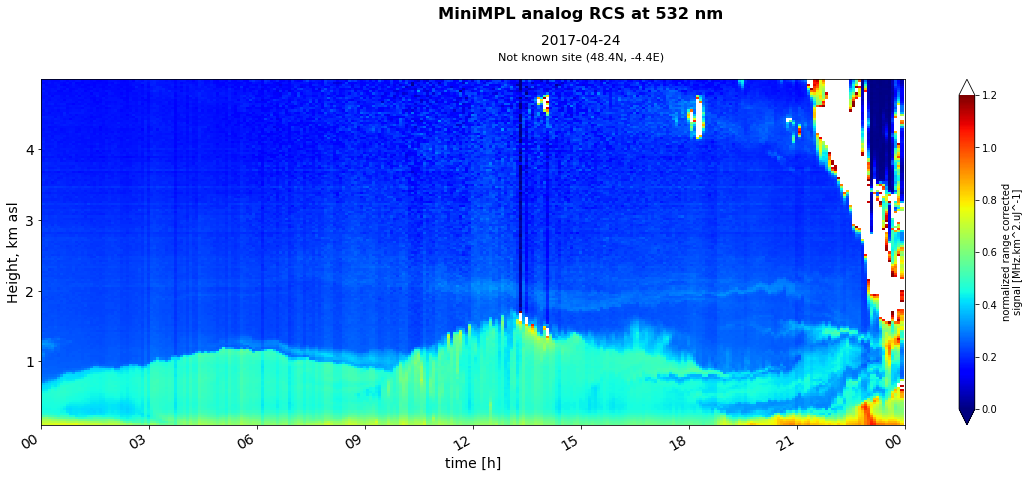

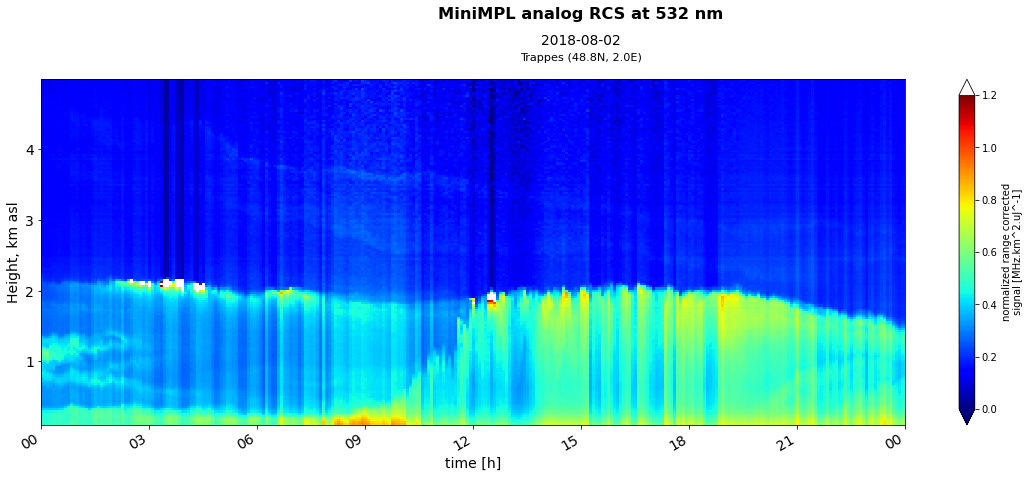

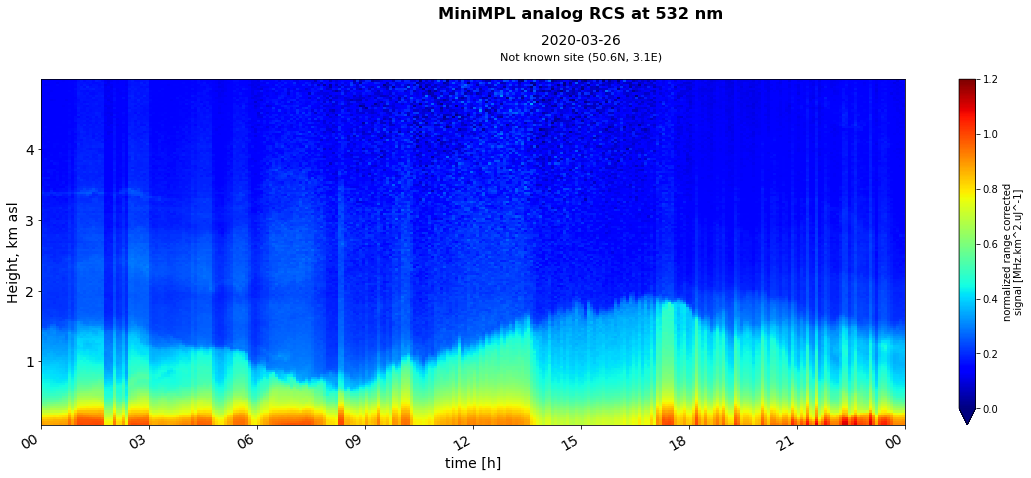

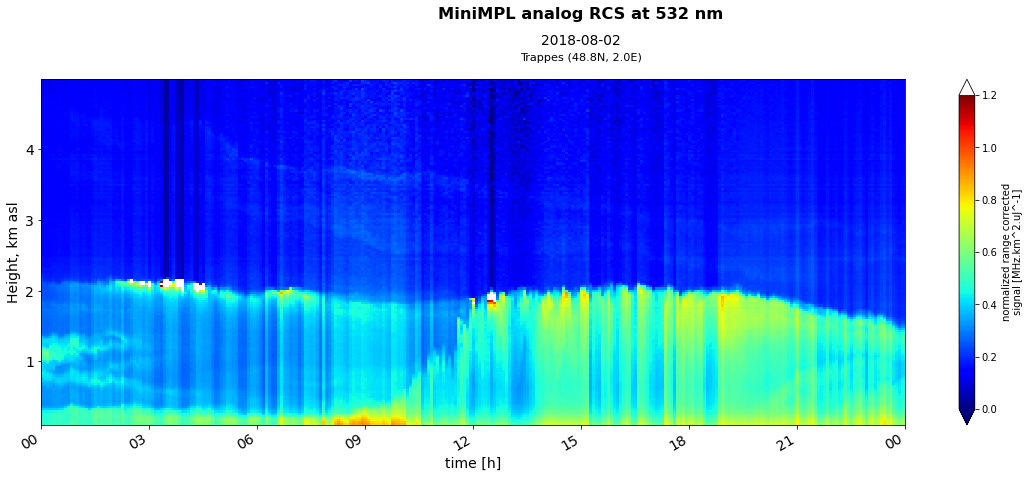

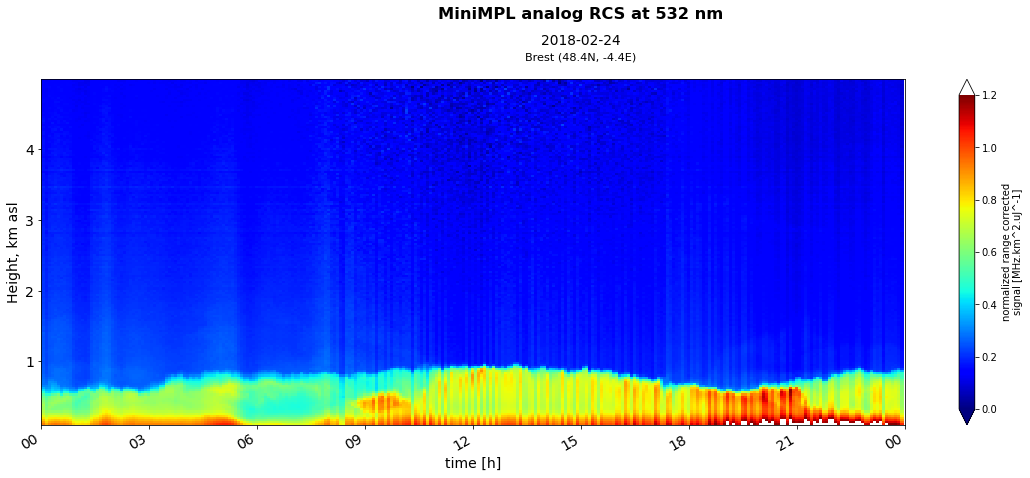

In [4]:
for filename in filenames:
  ds = xr.load_dataset(filename)
  ds = ds.assign_coords(range=ds.range/1000)

  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'rcs_0'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  plot_as_me(ds, 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=ds.attrs, 
            vmax=1.2,
            vmin=0,
            )

  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, km asl', fontsize=14)
  # year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
  # out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
  # fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
  # fl_name = os.path.join(out_dir, fl_name)
  # plt.savefig(fl_name, dpi=200)

In [40]:
filenames = ['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc', 
             '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

blh_human_path = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-human/'
blh_lidar_path = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-lidar/'

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


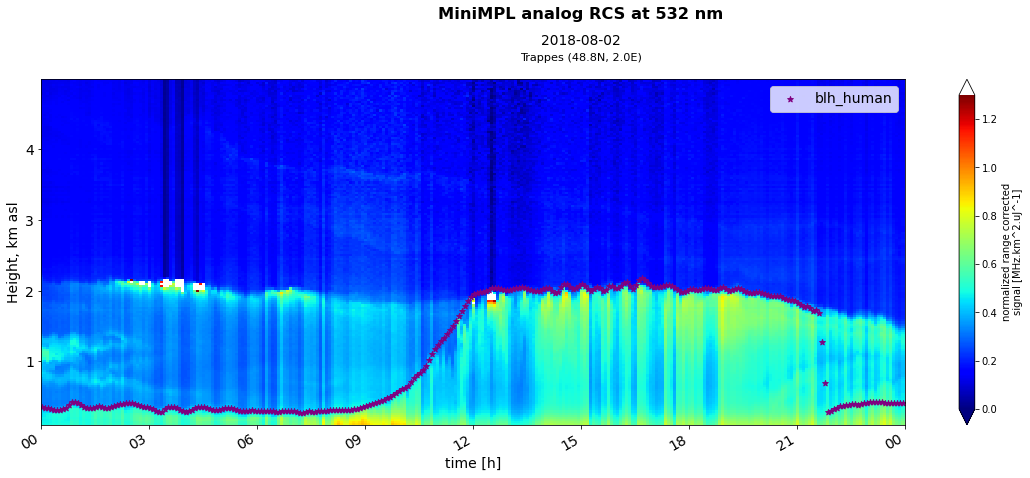

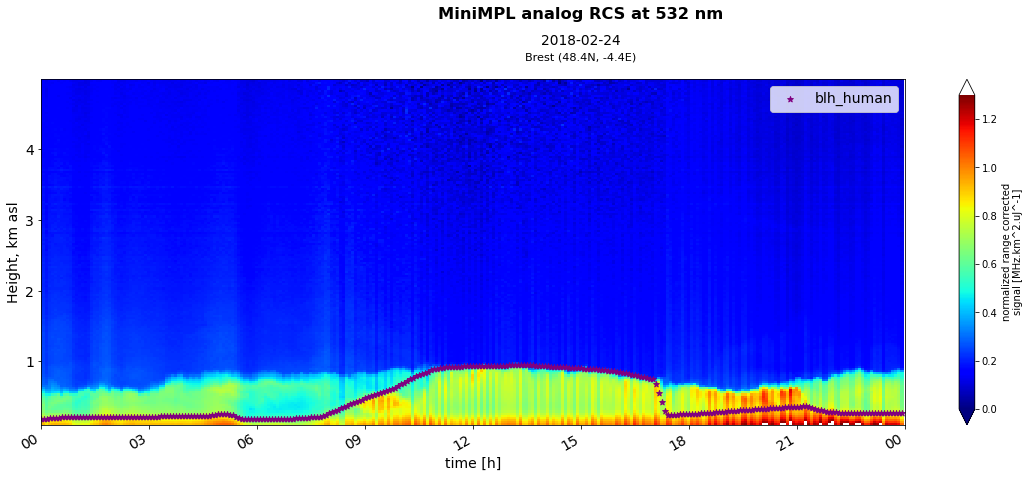

In [6]:
for filename in filenames:
  date = filename.split('/')[-1].split('.')[0].split('_')[-1]

  ds = xr.load_dataset(filename)
  ds = ds.assign_coords(range=ds.range/1000)
  site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))

  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'rcs_0'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  plot_as_me(ds, 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=ds.attrs, 
            vmax=1.3,
            vmin=0,
            )
  blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
  blh_human = pd.read_csv(blh_human_filename)
  blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)

  blh_lidar_filename = glob.glob(blh_lidar_path + '*' + site + '*')[0]
  blh_lidar = xr.load_dataset(blh_lidar_filename, decode_times=False)
  blh_lidar.assign_coords(time=[pd.Timestamp.fromtimestamp(date) for date in blh_lidar.time.values])

  plt.scatter(blh_human.t_values, blh_human.blh_ref/1000, c='purple', s=None, marker='*', label='blh_human')
  # blh_lidar.plot.scatter(x='time', y='BLH_INDUS')
  # plt.scatter(blh_lidar.time, blh_lidar.BLH_INDUS)
  plt.legend(fontsize=14)
  # pdb.set_trace()
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, km asl', fontsize=14)

# LIDAR FOURIER TRANSFORM

In [7]:
filenames = glob.glob('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL*.nc')
filenames

['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20170424.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.out.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5030_20200326.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

In [41]:
ds = xr.load_dataset(filenames[0])
ds

<xarray.Dataset>
Dimensions:                           (time: 288, range: 664, range_raw: 1000, range_vbp: 197, layer: 10)
Coordinates:
  * time                              (time) datetime64[ns] 2018-08-02T00:02:...
  * range                             (range) float32 119.9 149.9 ... 2e+04
  * range_raw                         (range_raw) float32 29.98 ... 2.998e+04
  * range_vbp                         (range_vbp) float32 119.9 ... 5.996e+03
  * layer                             (layer) int32 0 1 2 3 4 5 6 7 8 9
Data variables: (12/61)
    rcs_0                             (time, range) float64 0.4836 ... 0.03705
    bckgrd_rcs_0                      (time) float64 0.0007617 ... 0.0008135
    rcs_1                             (time, range) float64 0.4652 ... 0.03245
    bckgrd_rcs_1                      (time) float64 0.000359 ... 0.0003855
    rcs_2                             (time, range) float64 0.01835 ... 0.004606
    bckgrd_rcs_2                      (time) float64 0.0007617 ... 0.0008135
    ...                                ...
    vv                                (time) int32 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    ablh_gm1                          (time) float32 1.199e+03 ... 1.469e+03
    ablh_gm2                          (time) float32 1.319e+03 ... 1.409e+03
    ablh_gmlog                        (time) float32 1.379e+03 ... 1.499e+03
    ablh_gmcr                         (time) float32 1.379e+03 ... 1.469e+03
    ablh_fit                          (time) float64 nan nan nan ... nan nan nan
Attributes: (12/14)
    site_location:                Name of measurement station
    instrument_id:                MiniMPL
    institution:                  The institution or Met Service operating th...
    principal_investigator:       Department responsible for the instrument
    instrument_type:              Mini-MPL
    title:                        the site name and instrument type and manuf...
    ...                           ...
    overlap_function:             False
    overlap_is_corrected:         True
    source:                       SIRTA & UK Met Office
    references:                   
    comment:                      
    Conventions:                  CF-1.0, UKMO-1.0.2

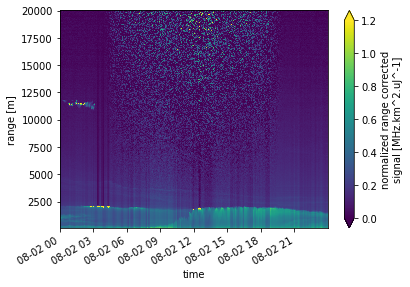

In [42]:
ds.rcs_0.plot.pcolormesh(y='range', vmin=0, vmax=1.2)

In [10]:
def apply_fft_ds(ds, channel:str='rcs_0', coord_name:str = 'range'):
  """
  Get the numpy fast fourier transform to the lidar profiles and append them to
  the dataset ds.

  Parameters:
  ----------
  ds: xarray.Dataset
    - Dataset to get the np.fft
  channel: str
    - Variable name of the variable to retrieve the np.fft
  coord_name: str
    - Coord name of the coordinate to retrieve de np.fft

  Returns:
  --------
  out: xarray.Dataset
    - Original Dataset ds with the np.fft and the frequencies coord saved.
  """

  coord_units = ds[coord_name].units
  channel_FT = xr.apply_ufunc(np.fft.fft, ds[channel])
  dfreqs = (1/max(ds[coord_name])).data
  out = ds.assign_coords({'freqs': ('freqs', np.arange(0, dfreqs*len(ds[coord_name]), dfreqs), {'units': '1/{}'.format(coord_units), 'long_name': 'frequencies'})})
  out = out.assign({'{}_fft'.format(channel): ({'time':out.time, 'freqs':out.freqs}, channel_FT.data, {'long_name': 'Fast Fourier transform of {}'.format(ds[channel].attrs['long_name'])})})
  # out = out['{}_fft'.format(channel)].assign_coords(freqs=out.freqs)
  # pdb.set_trace()

  return out

def dataarray_magnitude(da):
  """
  Get the magnitude of a xarray.Dataaray da with complex numbers
  """
  out = xr.apply_ufunc(np.real, ds.rcs_0_fft)**2 + xr.apply_ufunc(np.real, ds.rcs_0_fft) **2
  return xr.apply_ufunc(np.sqrt, out)


In [43]:
ds = xr.load_dataset(filenames[0])
ds = apply_fft_ds(ds)

In [44]:
ds.rcs_0_fft.sel(freqs=slice(0, len(ds.sel(range=slice(0,2500)).range)))

<xarray.DataArray 'rcs_0_fft' (time: 288, freqs: 664)>
array([[63.33950744 +0.j        , 18.31520603-22.36269706j,
        11.02334638-16.04183022j, ...,  7.77006545+13.87816991j,
        11.02334638+16.04183022j, 18.31520603+22.36269706j],
       [62.45692382 +0.j        , 17.81946096-22.19310417j,
        10.83689771-15.73396424j, ...,  8.05216811+13.3961468j ,
        10.83689771+15.73396424j, 17.81946096+22.19310417j],
       [62.60936501 +0.j        , 17.88711784-22.20545033j,
        11.06399923-15.75336027j, ...,  8.12460463+12.99028293j,
        11.06399923+15.75336027j, 17.88711784+22.20545033j],
       ...,
       [70.69136842 +0.j        , 18.23562835-22.54693403j,
        12.88170406-15.78060328j, ...,  9.63757623+14.06373759j,
        12.88170406+15.78060328j, 18.23562835+22.54693403j],
       [68.21146304 +0.j        , 17.38901749-21.77610932j,
        12.59159675-15.17110664j, ...,  9.01075442+13.18091169j,
        12.59159675+15.17110664j, 17.38901749+21.77610932j],
       [72.60869776 +0.j        , 18.77339953-23.06532671j,
        13.45505052-15.93716574j, ...,  9.73303244+14.00233463j,
        13.45505052+15.93716574j, 18.77339953+23.06532671j]])
Coordinates:
  * time     (time) datetime64[ns] 2018-08-02T00:02:00 ... 2018-08-02T23:57:00
  * freqs    (freqs) float64 0.0 5.001e-05 0.0001 ... 0.03306 0.03311 0.03316
Attributes:
    long_name:  Fast Fourier transform of normalized range corrected signal

## Perfiles, Trasanfromada de perfiles y quicklook

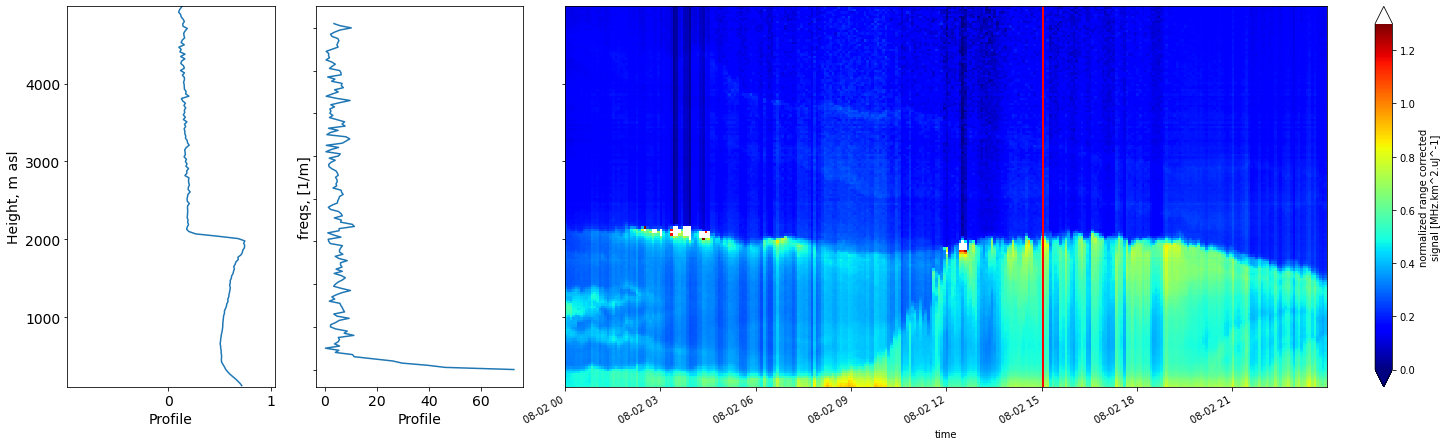

In [45]:
prf_of_interest = 180

fig, ax = plt.subplots(figsize=[26,7])

ax11 = plt.subplot(1,6,(1))
ax12 = plt.subplot(1,6,(2))
ax2 = plt.subplot(1,6,(3,6), sharey=ax11)


qt = 'RCS'
wl = '532'
signal_mode = 'analog'
channel = 'rcs_0'


max_range = 2500
fmax = 1/max_range

ds.sel(range=slice(0, 5000)).rcs_0.plot.pcolormesh(y='range', vmin=0, vmax=1.3, cmap='jet', axes=ax2)

endTime = ds.time[prf_of_interest] + np.timedelta64(1, 's')
start = mpl.dates.date2num(ds.time[prf_of_interest])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, 5000, linewidth=2,color='red',fill=False)

ax2.add_patch(rect)

ax11.plot(ds.rcs_0[prf_of_interest], ds.range)

ax12.plot(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, 5000)))]))[prf_of_interest], ds.freqs[0: len(ds.range.sel(range=slice(0, 5000)))])




# pdb.set_trace()


# dataarray_magnitude(ds.rcs_0_fft.sel(freqs=slice(0, len(ds.sel(range=slice(0,50)).range))))
# plt.title('FFT de la señal corregida de rango')

ax11.set_xlabel(r'Profile', fontsize=14)
ax11.set_ylabel('Height, m asl', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=14)
ax11.tick_params(axis='both', which='minor', labelsize=14)

ax12.set_xlabel(r'Profile', fontsize=14)
ax12.set_ylabel('freqs, [1/m]', fontsize=14)
ax12.tick_params(axis='both', which='major', labelsize=14)
ax12.tick_params(axis='both', which='minor', labelsize=14)


ax2.set_ylabel('')

o_ = plt.setp(ax2.get_yticklabels(), visible=False)
m_ = plt.setp(ax12.get_yticklabels(), visible=False)

## Transformada de Perfiles y transformada de quicklook

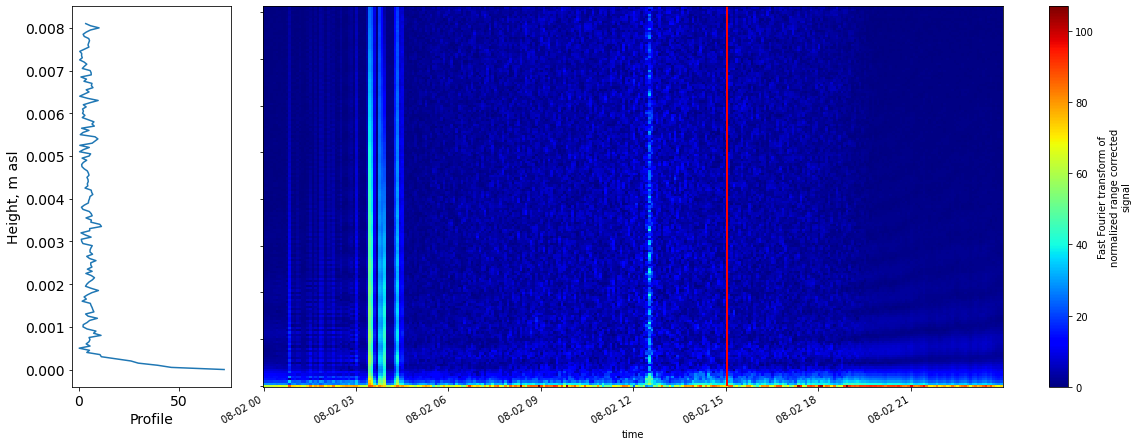

In [46]:
prf_of_interest = 180

fig, ax = plt.subplots(figsize=[20,7])

ax1 = plt.subplot(1,6,(1))
ax2 = plt.subplot(1,6,(2,6), sharey=ax11)


qt = 'RCS'
wl = '532'
signal_mode = 'analog'
channel = 'rcs_0'


max_range = 5000

np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])).plot.pcolormesh(y='freqs', vmin=0, vmax=None, cmap='jet', axes=ax2)

endTime = ds.time[prf_of_interest] + np.timedelta64(1, 's')
start = mpl.dates.date2num(ds.time[prf_of_interest])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)

ax2.add_patch(rect)

ax1.plot(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))[prf_of_interest], ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])




# pdb.set_trace()


# dataarray_magnitude(ds.rcs_0_fft.sel(freqs=slice(0, len(ds.sel(range=slice(0,50)).range))))
# plt.title('FFT de la señal corregida de rango')

ax1.set_xlabel(r'Profile', fontsize=14)
ax1.set_ylabel('Height, m asl', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)

ax2.set_ylabel('')

o_ = plt.setp(ax2.get_yticklabels(), visible=False)
m_ = plt.setp(ax12.get_yticklabels(), visible=False)

## Correlación cruzada de prfiles de línea

(0.0, 5000000000000000.0)

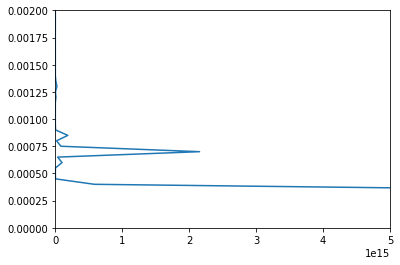

In [47]:
win_size = 8
# np.prod(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))[prf_of_interest-win_size: prf_of_interest+win_size+1], axis=0)

plt.plot(np.prod(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))[prf_of_interest-win_size: prf_of_interest+win_size+1], axis=0), ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])
plt.ylim([0, 0.002])
plt.xlim([0, 5e15])

<class 'numpy.ndarray'>


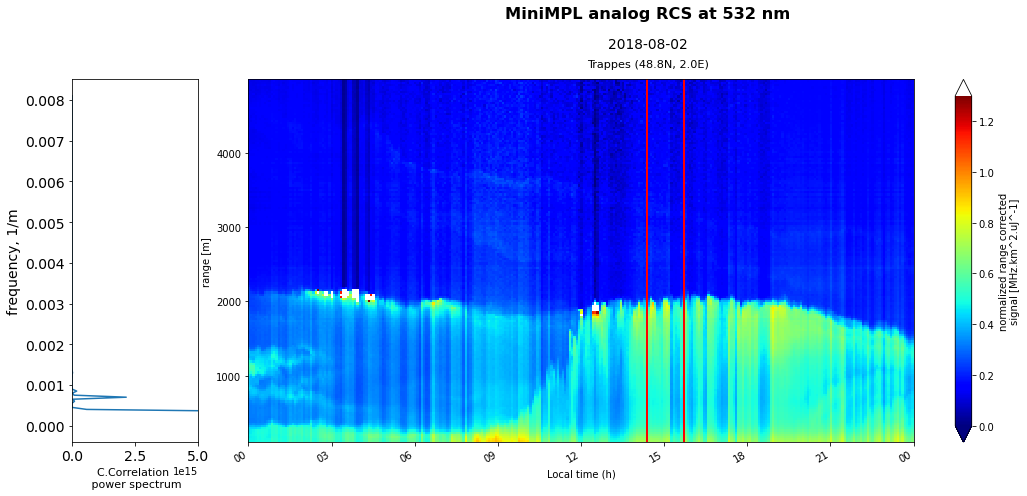

In [121]:
prf_of_interest = 180
win_size = 8

fig, ax = plt.subplots(figsize=[20,7])

ax1 = plt.subplot(1,6,(1))
ax2 = plt.subplot(1,6,(2,6))


qt = 'RCS'
wl = '532'
signal_mode = 'analog'
channel = 'rcs_0'


max_range = 5000

# np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])).plot.pcolormesh(y='freqs', vmin=0, vmax=None, cmap='jet', axes=ax2)
# pdb.set_trace()
plot_as_me(ds.sel(range=slice(0, max_range)), channel=channel, axes=ax2, qt=qt, wl=wl, signal_mode=signal_mode, attrs=ds.attrs, vmin=0, vmax=1.3)


ax1.plot(np.prod(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))[prf_of_interest-win_size: prf_of_interest+win_size+1], axis=0), ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])
ax1.set_xlim([0 ,5e15])
# ax1.set_ylim([0, 0.002])



# pdb.set_trace()


# dataarray_magnitude(ds.rcs_0_fft.sel(freqs=slice(0, len(ds.sel(range=slice(0,50)).range))))
# plt.title('FFT de la señal corregida de rango')

ax1.set_xlabel('C.Correlation \n power spectrum', fontsize=11)
ax1.set_ylabel('frequency, 1/m', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.ticklabel_format(axis='y', style='scientific')
# ax2.set_ylabel('')
ax2.set_xlabel('Local time (h)')

endTime = ds.time[prf_of_interest-win_size] + np.timedelta64(1, 's')
start = mpl.dates.date2num(ds.time[prf_of_interest-win_size])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)
ax2.add_patch(rect)

endTime = ds.time[prf_of_interest+win_size] + np.timedelta64(1, 's')
start = mpl.dates.date2num(ds.time[prf_of_interest+win_size])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)
ax2.add_patch(rect)
# fig.tight_layout()
# fig.tight_layout(pad=7.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.8,
                    top=0.82,
                    wspace=0.4,
                    hspace=0.4)

# o_ = plt.setp(ax2.get_yticklabels(), visible=False)


In [ ]:
np.prod([[1,2]], axis=0)

array([1, 2])